# Fetching Link Data

This notebook take you through the work necessary to generate a list of NYC Board of Election results.

## Introduction

The New York City Board of Elections (BOE) distributes raw ballot totals on their website at [`vote.nyc.ny.us`](http://vote.nyc.ny.us/html/results/2015.shtml). These "Certified Election Results" take the form of `PDF` documents segmented by year going back to 2005; election results from 1999-2004 are also available, though on a [single page](http://vote.nyc.ny.us/html/results/2004_previous.shtml).

The vast majority of these `PDF` documents are in one of two formats. A newer format, which has been used since 2005:

In [1]:
from IPython.display import Image

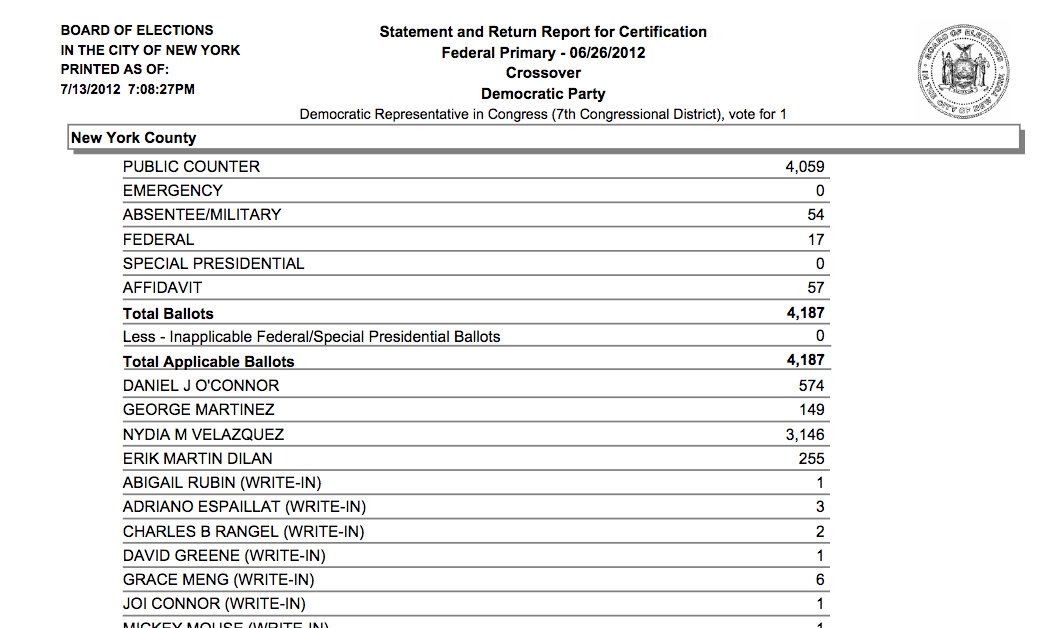

In [4]:
Image("../figures/nyc-boe-new-form.png")

And an old form used in 2004 through 1999:

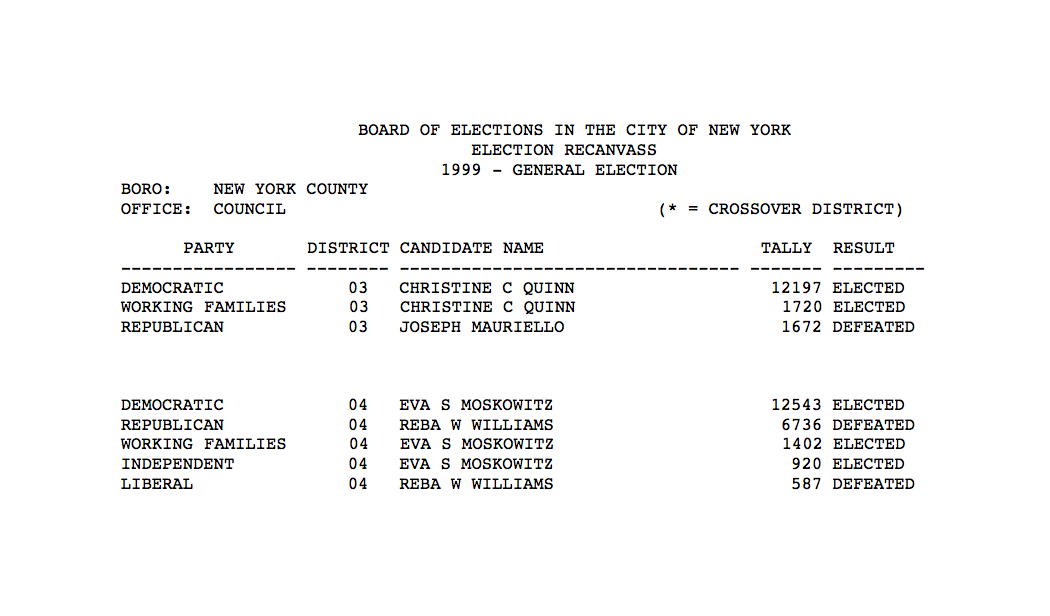

In [6]:
Image("../figures/nyc-boe-old-form.png")

Certain expections, seemingly pertaining to certain special elections, exist.

Results from 2004 through 1999 are relatively spare in number because data was globbed into large documents, like this [1780-page monster](http://vote.nyc.ny.us/downloads/pdf/results/2000/generalelection/allg2000.pdf) of election results from 2000. Reporting became much more granular from 2005 on, with the corresponding increase in document numbers and split of the documents into a year-by-year format.

The BOE changed the format of its releases in 2014 on, presenting the data in tabulated format and also providing `CSV` dumps of the raw data, not just PDFs. Progress, you might say! Not really. The CSVs contain the data, this is true, but on examination they look like a poorly done direct transfer from the PDF to a spreadsheet, containing all of the same formatting strings as the PDF originals.

Since they're in a CSV, not a PDF, these are *marginally* easier to work with. But since we're going to have write a PDF reader anyway, the whole thing is pointless. Good job, government.

This means that the gamut of data on the site can be seperated into two extraction "eras":

1. 2005 - 2015 &mdash; Extract from new-style `PDF` forms.
2. 1999 - 2004 &mdash; Extract from old-style `PDF` forms.

But we're getting ahead of ourselves. Before we do any parsing of the actual documents, however, we must first manage the macro-structure of the data&mdash;the data about the data, so to speak.

From 2005 to 2012, PDF document link text looks something like this: `New York City Council 2 Recap (pdf)`. In 2012 and 2013 this was changed to `Bronx Member of the City Council 12th Council District Recap (pdf)`. In 2014 and 2015 link text was abolished entirely; data is now provided via a table, with data available in `CSV` format. But, albeit with the addition of some junk numbers at the beginning and the removal of the `(pdf)` segment of the string, the text in the actual link target is the same as that used in 2012 and 2013 (example: `http://vote.nyc.ny.us/downloads/pdf/election_results/2015/20151103General Election/00102401008New York Judge of the Civil Court - District 8th Municipal Court District - New York Recap.pdf`).

Hum. Getting these links categorically sorted properly is going to take manual effort.

## Fetch Links

In [51]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm

hrefs = []
link_strings = ['2004_previous'] + list(range(2005, 2015))
for year in tqdm(link_strings):
    r = requests.get("http://vote.nyc.ny.us/html/results/{0}.shtml".format(year))
    soup = BeautifulSoup(r.text, 'html.parser')
    # Fetch all CSV-type links.
    links = [l for l in soup.findAll('a', href=True) if ((".pdf" in l['href']) and
                                                         ("election_results" in l['href'] 
                                                          or "results" in l['href']) and
                                                         ("EDLevel" not in l['href']) and
                                                         ("Citywide" not in l['href']))]
    relative_hrefs = ["/".join(l['href'].split("/")[2:]).replace("%20", "") for l in links]
    hrefs += ["http://vote.nyc.ny.us/" + href for href in relative_hrefs]

100%|██████████| 11/11 [00:04<00:00,  1.62it/s]


In [37]:
len(hrefs)

2497

In [39]:
hrefs[:20]

['http://vote.nyc.ny.us/downloads/pdf/results/2004/general/g2004recaps.pdf',
 'http://vote.nyc.ny.us/downloads/pdf/results/2004/general/g2004aded.pdf',
 'http://vote.nyc.ny.us/downloads/pdf/results/2004/primary/p2004newyork.pdf',
 'http://vote.nyc.ny.us/downloads/pdf/results/2004/primary/p2004bronx.pdf',
 'http://vote.nyc.ny.us/downloads/pdf/results/2004/primary/p2004kings.pdf',
 'http://vote.nyc.ny.us/downloads/pdf/results/2004/primary/p2004queens.pdf',
 'http://vote.nyc.ny.us/downloads/pdf/results/2004/primary/p2004richmond.pdf',
 'http://vote.nyc.ny.us/downloads/pdf/results/2004/primary/p2004crossover.pdf',
 'http://vote.nyc.ny.us/downloads/pdf/results/2004/primary/p2004writeins.pdf',
 'http://vote.nyc.ny.us/downloads/pdf/results/2004/presidentialprimary/pp2004.pdf',
 'http://vote.nyc.ny.us/downloads/pdf/results/2003/general/g2003recaps.pdf',
 'http://vote.nyc.ny.us/downloads/pdf/results/2003/primary/2003primaryrecapsall.pdf',
 'http://vote.nyc.ny.us/downloads/pdf/results/2003/speci

## Back out Years

The following line generates a list for testing my regex with [`regexr`](http://regexr.com/).

In [52]:
import random
random.sample(hrefs, 500)

['http://vote.nyc.ny.us/downloads/pdf/results/2008/general/0.09CrossoverStateSenate25_Recap.pdf',
 'http://vote.nyc.ny.us/downloads/pdf/results/2007/primary/4.5NYDemocraticCountyCommitteeED015AD72Recap.pdf',
 'http://vote.nyc.ny.us/downloads/pdf/results/2006/general/recaps/81NY26SenateRecap.pdf',
 'http://vote.nyc.ny.us/downloads/pdf/election_results/2014/20140909Primary Election/01104700075New York Democratic Alternate Delegate to the Judicial Convention 75th Assembly District Recap.pdf',
 'http://vote.nyc.ny.us/downloads/pdf/results/2003/general/g2003recaps.pdf',
 'http://vote.nyc.ny.us/downloads/pdf/results/2009/Primary/1.13KingsDemMayorRecap.pdf',
 'http://vote.nyc.ny.us/downloads/pdf/results/2013/2013SeptemberPrimaryElection/02059640783Kings Republican County Committee 078 64 Recap.pdf',
 'http://vote.nyc.ny.us/downloads/pdf/results/2008/Queens30Council/Queens30CouncilRecap.pdf',
 'http://vote.nyc.ny.us/downloads/pdf/results/2008/general/4.47QueensAssembly28_Recap.pdf',
 'http://v

In [ ]:
hrefs

In [44]:
import re

years = []
re_date = re.compile("(1999|2000|2001|2002|2003|2004|2005|2006|2007|2008|2009|2010|2011|2012|2013|2014|2015)")
years = [int(re_date.findall(href)[0]) for href in hrefs]

## Back out Election Type

In [48]:
types = []
re_type = re.compile("(primary|Primary|general|General|special|Special)")
types = [re_type.findall(href)[0].title() if re_type.findall(href) else 'Other' for href in hrefs]

In [50]:
pd.Series(types).value_counts()

Primary    1299
General    1158
Special      35
Other         5
dtype: int64

## Combine and Save

In [55]:
data = pd.DataFrame({'link': hrefs, 'year': years, 'type': types})

In [56]:
data.sample(5)

,link,type,year
976,http://vote.nyc.ny.us/downloads/pdf/results/20...,Primary,2009
1338,http://vote.nyc.ny.us/downloads/pdf/results/20...,Primary,2010
1354,http://vote.nyc.ny.us/downloads/pdf/results/20...,Primary,2010
1641,http://vote.nyc.ny.us/downloads/pdf/results/20...,Primary,2012
1823,http://vote.nyc.ny.us/downloads/pdf/results/20...,General,2013


In [58]:
!mkdir "../data"

In [59]:
data.to_csv("../data/certified_election_result_links.csv")